Introduction to KG Builder Notebook
==============

KG Builder is a library that we have developed to build three pipelines for knowledge creation (extracting data mainly from Wikidata). The knowledge graphs created can then be used for various purposes such as data analysis, machine learning, and knowledge management. For more information, please refer to the paper *Strategies for creating knowledge graphs to depict a multi-perspective Queer communities representation* present alongside this notebook.

The three pipelines that we have created using KG Builder are:

-**Pure SPARQL**

-**Star Merging**

-**Crawler**

In this notebook, we will describe each of these pipelines in detail and provide examples of how they can be used. We will also demonstrate how to use KG Builder to clean, handle, visualize and analyse the knowledge graphs. Overall, this notebook aims to provide a comprehensive guide to using KG Builder for knowledge creation using Wikidata.

# Installing the dependencies

Due to the visualization tools used, specific versions of networkx and scipy are required

In [1]:
!pip install -U pip
!pip install rdflib
!pip install datashader

!pip install --upgrade networkx==2.6 scipy==1.8.0

  Using cached networkx-2.6-py3-none-any.whl (1.9 MB)
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0rc3 Requires-Python >=3.8,<3.12; 1.9.1 Requires-Python >=3.8,<3.12; 1.9.2 Requires-Python >=3.8; 1.9.3 Requires-Python >=3.8; 2.7 Requires-Python >=3.8; 2.7.1 Requires-Python >=3.8; 2.7rc1 Requires-Python >=3.8; 2.8 Requires-Python >=3.8; 2.8.1 Requires-Python >=3.8; 2.8.1rc1 Requires-Python >=3.8; 2.8.2 Requires-Python >=3.8; 2.8.3 Requires-Python >=3.8; 2.8.4 Requires-Python

In [1]:
"""from rdflib import Graph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph,rdflib_to_networkx_digraph
import networkx as nx
import matplotlib.pyplot as plt

import requests

import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle


from itertools import chain

import scipy"""

import datashader.transfer_functions as tf

In [2]:
from queries import *
from visuals import create_plot_graph_force_directed

# Star Merging Pipeline

This pipeline starts with a SPARQL query to Wikidata that returns a list of Wikidata item IDs that are related to the queer community.This list is then used to create a merged RDF graph using the RDF data of the nodes from the Wikidata entity URLs in ntriples format. This merged graph is then converted to a NetworkX multidigraph that is then pruned and cleaned in various ways.

In [3]:
from star_merging import star_merging_pipeline

help(star_merging_pipeline)

Help on function star_merging_pipeline in module star_merging:

star_merging_pipeline(n, query, prune_policy)
    This function performs a star merging pipeline with the given parameters.
    
    Args:
        n (int): The number of items to retrieve from the SPARQL query.
        query (str): The SPARQL query string to use.
        prune_policy (str): The policy to use for pruning the merged graph.
    
    Returns:
        tuple: A tuple containing the merged graph and the list of items retrieved from the SPARQL query.



In [4]:
prune_policy=['deadend','apply','isolated','apply']
G,l=star_merging_pipeline(15, query_queer_world, prune_policy)

Force-directed

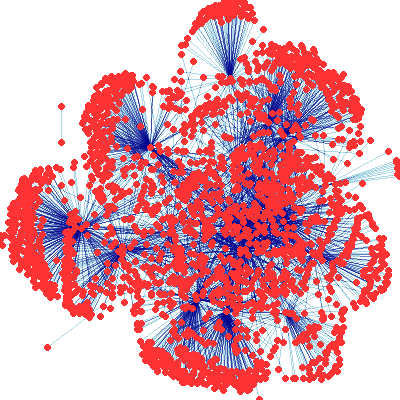

In [5]:
image=create_plot_graph_force_directed(G)
tf.Images(image).cols(1)

# Crawler

In contrast to the global approach of the previous pipelines, this pipeline starts with a small number of nodes and runs an iterative process to extract important nodes that represent properties of interest (potential common points) and use those to explore and discover more queer people and communities. This pipeline runs with a PageRank algorithm on an initial set of nodes. The PageRank algorithm is run multiple times with different parameters, such as the damping factor (alpha) and the number of iterations. After the PageRank algorithm has been run, the pipeline selects a certain number of the most important nodes (k_prop) and uses them to explore further. Specifically, it runs the same SPARQL query as before, but this time using the selected nodes as the property of interest. The result is a new set of nodes that are connected to the previously selected nodes through the property of interest. These new nodes are added to the original graph, and the process repeats.

In [6]:
from crawler import *

help(crawler_process)

Help on function crawler_process in module crawler:

crawler_process(G, n_iter, k_prop, n_incr, policy, n_max=None, people_list=[], alpha=0.85, pagerank_iter=100)
    A function that crawls Wikidata for information about people based on their properties.
    
    Args:
        G (networkx graph): the starting graph
        n_iter (int): the number of iterations to run the crawler for
        k_prop (int): the number of properties to explore at each iteration
        n_incr (int): the number of new people to query Wikidata for each time a property is explored
        policy (str): the policy to use when querying Wikidata for new people (either "wd" or "spdq")
        n_max (int): the maximum number of people to crawl for
        people_list (list): the list of people already found
        alpha (float): the damping factor to use when computing PageRank
        pagerank_iter (int): the number of iterations to use when computing PageRank
    
    Returns:
        G (networkx graph): the f

In [7]:
prune_policy=['deadend','apply','isolated','apply']
G,l=star_merging_pipeline(2, query_queer_world, prune_policy)

In [8]:
new_G,new_l=crawler_process(G, 20, 1, 5, prune_policy, n_max=15, people_list=l)

[rdflib.term.URIRef('http://www.wikidata.org/entity/Q58284')]
[rdflib.term.URIRef('http://www.wikidata.org/entity/Q592')]
[rdflib.term.URIRef('http://www.wikidata.org/entity/Q188')]
[rdflib.term.URIRef('http://www.wikidata.org/entity/Q1055')]
[rdflib.term.URIRef('http://www.wikidata.org/entity/Q11920')]
[rdflib.term.URIRef('http://www.wikidata.org/entity/Q15706812')]
[rdflib.term.URIRef('http://www.wikidata.org/entity/Q107343683')]
[rdflib.term.URIRef('http://www.wikidata.org/entity/Q64')]
15 peoples reached


Force-directed

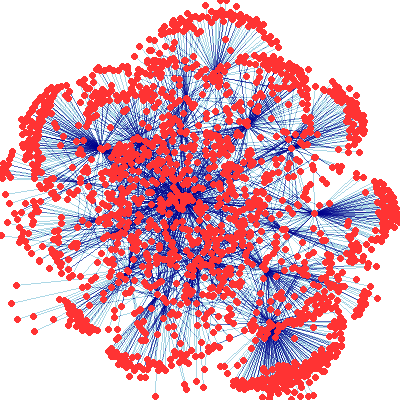

In [9]:
image=create_plot_graph_force_directed(new_G)
tf.Images(image).cols(1)

# More Graph Visualization

## Layout and edge-bundling

The layout of the nodes can heavily influence the visual representation of the graph, we favored the force-directed layout. Additionally, we also implemented some edge-bundling which is a method that allows edges to curve and then group nearby ones together to help convey structure

In [14]:
from visuals import create_plot_graph_force_directed_bundled

prune_policy=['deadend','apply','isolated','apply']
smallG,small_l=star_merging_pipeline(7, query_queer_world, prune_policy)

"Force-directed, bundled"

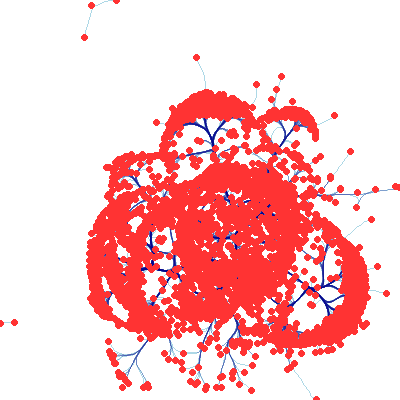

In [15]:
from visuals import create_plot_graph_force_directed_bundled

image=create_plot_graph_force_directed_bundled(smallG)
tf.Images(image).cols(1)

## Pruning process

Force-directed

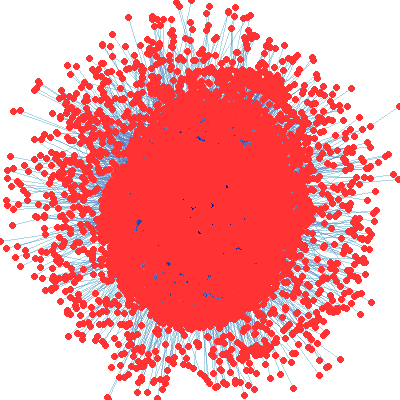

In [16]:
#without anything removed
smallG,small_l=star_merging_pipeline(7, query_queer_world, [])
image=create_plot_graph_force_directed(smallG)
tf.Images(image).cols(1)

Force-directed

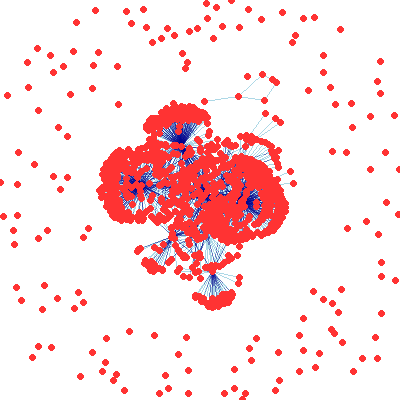

In [18]:
#without the isolated nodes removed
smallG,small_l=star_merging_pipeline(7, query_queer_world, ['deadend','apply'])
image=create_plot_graph_force_directed(smallG)
tf.Images(image).cols(1)

# Graph Analysis

# Exporting the graph

This was also very useful because we had to fragment the merging into 8 different graphs when evaluating for the entirety of the queer people with data on wikidata.

In [ ]:
from networkx.readwrite import json_graph
import json

g_json=json_graph.node_link_data(G)
json.dump(g_json,open("graph.json","w"))